In [1]:
%reset -f

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import  pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Attention, Reshape, Multiply
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from dataclasses import dataclass, asdict
import yaml
from typing import Optional, Union, List
from dacite import from_dict
import numpy as np
import math
import json
import itertools
import ast
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import random
from random import randrange
import pandas as pd
%matplotlib inline

### checking if GPU available

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Utilities (only run once)

In [193]:
import numpy as np
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir): #https://www.geeksforgeeks.org/os-walk-python/
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir)) #https://www.geeksforgeeks.org/python-os-path-basename-method/
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name #???????????????????????
        testing_data_category_dir = testing_data_dir + '/' + category_name #???????????????????????

        if not os.path.exists(training_data_category_dir): #???????????????????????
            os.mkdir(training_data_category_dir)           #???????????????????????

        if not os.path.exists(testing_data_category_dir):  #???????????????????????
            os.mkdir(testing_data_category_dir)            #???????????????????????

        for file in files:
            input_file = os.path.join(subdir, file) #https://www.geeksforgeeks.org/python-os-path-join-method/
            if np.random.rand(1) < testing_data_pct: #https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                #https://www.geeksforgeeks.org/python-shutil-copy-method/
                #shutil.copy() also copies permission bits, as well as the...
                #contents of the file. shutil.copyfile only copies the data.
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [195]:
# all_data_dir = '/home/ubuntu/data/isic-2019/images_by_class/'
# training_data_dir = '/home/ubuntu/data/isic-2019/isic_train_by_class/'
# testing_data_dir = '/home/ubuntu/data/isic-2019/isic_test_by_class/'
# testing_data_pct = 0.2
# split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct)

Successfully cleaned directory /home/ubuntu/data/isic-2019/isic_test_by_class/
Successfully cleaned directory /home/ubuntu/data/isic-2019/isic_train_by_class/
 vs 
BCC vs 
others vs 
MEL vs 
Processed 20223 training files.
Processed 5108 testing files.


### Data Augmentation and Upsampling

In [277]:
class Data_augmentation:
    def __init__(self, image):
        '''
        Import image
        :param path: Path to the image
        :param image_name: image name
        '''
        self.image = cv2.imread(image)
        #print(image)

    def rotate(self, image, angle=90, scale=1.0):
        '''
        Rotate the image
        :param image: image to be processed
        :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
        :param scale: Isotropic scale factor.
        '''
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

    def flip(self, image, vflip=False, hflip=False):
        '''
        Flip the image
        :param image: image to be processed
        :param vflip: whether to flip the image vertically
        :param hflip: whether to flip the image horizontally
        '''
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 
    
    
    def image_augment(self): 
        '''
        Create the new image with imge augmentation
        :param path: the path to store the new image
        ''' 
        rotate_range = [90,180]
        vflip = bool(random.randrange(2))
        hflip = bool(random.randrange(2))
        
        image = self.image
        
        image = self.rotate(image, rotate_range[random.randrange(len(rotate_range))])
        image = self.flip(image, vflip, hflip)
        return image

In [278]:
#upsampling

training_data_dir = '/home/ubuntu/data/isic-2019/isic_train_by_class/'
aug_size = 3000
rand_images = {}
for dir in os.listdir(training_data_dir):
    images = os.listdir(f"{training_data_dir}/{dir}")
    images_count = len(images)
    to_balance = aug_size - images_count
    print(dir, images_count, to_balance)
    rand_images[dir] = list()
    for i in range(to_balance):
        rand = randrange(images_count - 1)
        rand_images[dir].append(rand)
        img_path = f"{training_data_dir}/{dir}/{images[rand]}"
        img_aug = Data_augmentation(img_path).image_augment()
        cv2.imwrite(f"{img_path.split('.')[0]}_aug{i}.jpg", img_aug)

mel 3575 -575
others 13977 -10977
bcc 2671 329


# Objects and Classes

In [4]:
@dataclass
class Resize:
    resizeW: int
    resizeH: int

@dataclass
class DullRazor:
    enabled: bool
    razorblur: str
    mediankernel_razorblur: int
    filterstructure:int
    lowerbound:int
    inpaintmat:int

@dataclass
class Blur:
    enabled: bool
    normalblur: str
    mediankernel_blur: int
    blurnum: int

@dataclass
class Softattention:
    alpha: float
    beta: float
    gamma: float
    
@dataclass
class AttentionConfig:
    resize: Resize
    dull_razor: DullRazor
    blur: Blur
    soft_attention: Softattention
        
@dataclass
class LossParams:
    func: str
    params: Optional[str]

@dataclass
class OptimizerParams:
    func: str
    params: Optional[str]

@dataclass
class InputDataParams:
    input_size: str

@dataclass
class ModelParams:
    batch_size: int
    arch: str
    freeze_pretrained: bool
    steps_per_epoch: int
    metrics: List[str]
    pretrained_weight: Optional[str]
    loss: Optional[LossParams]
    optimizer: Optional[OptimizerParams]
    class_weight_mu: float

@dataclass
class ModelsConfig:
    model_name: str
    input_params: InputDataParams
    model_params: ModelParams
    attention_config: Optional[AttentionConfig]

# Yaml for ResNet50

In [6]:
#yaml for ResNet50
yaml_config3 = """
ham_10k_resnet50_512v2:
  model_name: "HAM_10k_ResNet50_512v2"
  input_params:
    input_size: (512,512)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      

ham_10000_resnet50:
  model_name: "HAM_10000_ResNet50"
  input_params:
    input_size: (224,224)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-5}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10000_resnet50_3D&D600450:
  model_name: "ham_10000_resnet50_3D&D600450"
  input_params:
    input_size: (128,128)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10k_resnet50_600450:
  model_name: "HAM_10k_ResNet50_600450"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10k_resnet50_512:
  model_name: "HAM_10k_ResNet50_512"
  input_params:
    input_size: (512,512)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10000_resnet50_noextralayers:
  model_name: "ham_10000_resnet50_noextralayers"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10000_resnet50_4D&D:
  model_name: "ham_10000_resnet50_4D&D"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
"""


In [7]:
class Ham10000Attention:
    
    def __init__(self, model, attention_config):
        self.config = attention_config
        
        self.input_shape = (self.config.resize.resizeW, self.config.resize.resizeH)
        self.model = model
        #self.attention_output = self.heatmap(self.image, model)
    
    def resize(self, img):
        return cv2.resize(img, self.input_shape, interpolation=cv2.INTER_LINEAR)    
            
    def dull_razor(self, img):
        cfg = self.config.dull_razor
        if cfg.razorblur == "M":
            img = cv2.medianBlur(img,cfg.mediankernel_razorblur)
        elif cfg.razorblur == "G":
            img = cv2.GaussianBlur(img, (cfg.mediankernel_razorblur, cfg.mediankernel_razorblur),0)

        #gyimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #filtersize = (cfg.filterstructure,cfg.filterstructure)
        #kernelrazor = cv2.getStructuringElement(cv2.MORPH_RECT, filtersize)
        #gyimage = cv2.morphologyEx(gyimage, cv2.MORPH_BLACKHAT, kernelrazor)
#
        #retrazor, maskrazor = cv2.threshold(gyimage, cfg.lowerbound, 255, cv2.THRESH_BINARY)
        #img = cv2.inpaint(img, maskrazor, cfg.inpaintmat, cv2.INPAINT_TELEA)
        return img

    def blur(self, img):
        cfg = self.config.blur
        if cfg.normalblur == "M":
            img = cv2.medianBlur(img, cfg.mediankernel_blur)
        elif cfg.normalblur == "G":
            img = cv2.GaussianBlur(img, (cfg.mediankernel_blur, cfg.mediankernel_blur), 0)
        return img

    def softention_preprocess(self, img):
        first = preprocess_input(img)
        expanded_image = np.expand_dims(first, 0)
        return expanded_image

    def softention_mapping(self, img, LayerNumber, input_shape, SoftentionImage):
        cfg = self.config.soft_attention
        activated = self.model.predict(img)
        output = np.abs(activated)
        output = np.sum(output, axis = -1).squeeze() 
        output = cv2.resize(output, input_shape)
        output /= output.max() 
        #output *= 255 
        #Weights =  255 - output.astype('uint8')
#
        #heatmap = cv2.applyColorMap(Weights, cv2.COLORMAP_JET)
        #heatmap = cv2.addWeighted(heatmap, cfg.alpha, SoftentionImage, cfg.beta, cfg.gamma)
        return output
    
    def heatmap(self, img):
        #resized_image = self.resize(img)
        hair_removed_image = self.dull_razor(img)
        softentionImage = self.blur(hair_removed_image)
        expanded_image = self.softention_preprocess(softentionImage)
        heatmap = self.softention_mapping(expanded_image, -1, self.input_shape, softentionImage)
        return heatmap
    
    def preprocess(self, img):
        
        img = self.resize(img)
        heatmap = self.heatmap(img)
        mask = heatmap.reshape(self.config.resize.resizeW,self.config.resize.resizeH,1)
        out = Multiply()([tf.cast(img, tf.float32),mask])
        img = tf.keras.utils.normalize(out)
        return img

In [8]:
class ModelTrainer():

  def __init__(self, train_dir, test_dir, model_name, model_dir, batch_size = 16, 
               target_size = (224,224), model_params = None, class_weight_mu = 0.4, 
               attention_config = None,retrain = False, model_weights = "imagenet"):
    self.train_dir = train_dir
    self.test_dir = test_dir
    self.batch_size = batch_size
    self.target_size = target_size
    self.model_name = model_name
    self.model_dir = model_dir
    self.checkpoint_path = f"{self.model_dir}/{self.model_name}"
    if attention_config:
        print("attention model")
        self.attention_model = self.attention(attention_config)
    else:
        self.attention_model = None
    self.train_generator, self.validation_generator, self.attention_generator = self.get_generators()
    self.set_class_weight(class_weight_mu)
    self.model_params = model_params
    self.retrain = retrain
    self.model_weights = model_weights
    if retrain == True or not(self.load_trained_model()):
      if model_params:
        self.register_model(self.model_architecture(model_params))
    self.class_indices = self.train_generator.class_indices
    self.index_to_class = {self.class_indices[k]:k for k in self.class_indices}


    
  @staticmethod
  def load_from_config(config, base_dir = '/home/ubuntu/data/3classes/', train_dir = "HAM10000_train_by_class", 
                       test_dir = "HAM10000_test_by_class",
                       retrain = False,
                       model_weights = "imagenet"):
    train_dir = f"{base_dir}/{train_dir}/"
    test_dir = f"{base_dir}/{test_dir}/"
    model_dir = f"{base_dir}/models"
    cfg = from_dict(data_class=ModelsConfig, data=config)
    model_trainer = ModelTrainer(train_dir, test_dir, cfg.model_name, model_dir, batch_size = cfg.model_params.batch_size or 16,
                                 target_size = eval(cfg.input_params.input_size),class_weight_mu = cfg.model_params.class_weight_mu,
                                 model_params = cfg.model_params, attention_config = cfg.attention_config, retrain = retrain, 
                                 model_weights = model_weights)    
    return model_trainer

  @classmethod
  def img_normalize(cls,img, mean, sd):
    #img = cv2.imread(img)
    #mean = [0.5456423, 0.5700427, 0.7630366]
    #sd = [0.15261365, 0.16997027, 0.14092803]
    img = cv2.resize(img, (224,224))
    img = img.astype('float32')/255.
    img = (img - mean) / sd
    #img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
    return img     
  
  def attention(self, attention_config):
    attention_pretrained_model = ResNet50(input_shape=(224,224, 3),
                                                include_top=False,
                                                weights='imagenet')
    out_layer = attention_pretrained_model.layers[-1]
    model = tf.keras.models.Model(inputs = attention_pretrained_model.inputs, outputs = out_layer.output)
    return Ham10000Attention(model,attention_config)
  
  def register_model(self, model):
    self.model = model
    self.model.compile(loss=self.model_params.loss.func, optimizer=self.optimizer(), metrics=self.model_params.metrics)
    if not os.path.exists(self.checkpoint_path):
        os.makedirs(self.checkpoint_path)
    if self.retrain:
        self.model.save(f"{self.checkpoint_path}/model.h5")
    else:
        self.load_trained_model()
        self.model.save(f"{self.checkpoint_path}/model.h5")

  def optimizer(self):
    optimizer_func = eval(self.model_params.optimizer.func)
    optimizer_params = ast.literal_eval(self.model_params.optimizer.params)
    optimizer = optimizer_func(**optimizer_params)
    return optimizer

  def summary(self):
    self.model.summary()

  def show_samples(self, rows = 4, columns = 4):
    x, y = next(self.train_generator)
    fig = plt.figure(figsize=(8, 8))
    for i in range(0, columns*rows):
      img = x[i].astype(int)
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(img)
    plt.show()
  
  def get_generators(self):
    self.train_datagen = ImageDataGenerator(
                                  featurewise_center=True, 
                                  featurewise_std_normalization=True
                                  #rotation_range = 20,
                                  #width_shift_range = 0.2,
                                  #height_shift_range = 0.2,
                                  #shear_range = 0.2,
                                  #horizontal_flip = True,
                                  #vertical_flip = True,
                                  #preprocessing_function = ModelTrainer.img_normalize)
                                  #preprocessing_function = self.attention_model.preprocess
                                  #self.attention_model.preprocess)
                                  #fill_mode = 'nearest'
                                    )
    self.test_datagen = ImageDataGenerator(
                                     featurewise_center=True, 
                                    featurewise_std_normalization=True
                                    #preprocessing_function = self.attention_model.preprocess
                                     )
    if self.attention_model:
        attention_generator = ImageDataGenerator(preprocessing_function = self.attention_model.heatmap)
    else:
        attention_generator = None
    
    train_generator = self.train_datagen.flow_from_directory(directory=self.train_dir, class_mode='sparse',shuffle=True,
                                                  batch_size=self.batch_size,target_size=self.target_size)
    validation_generator = self.test_datagen.flow_from_directory(directory=self.test_dir, class_mode='sparse',shuffle=False,
                                                       batch_size=self.batch_size,target_size=self.target_size)
    return train_generator, validation_generator, attention_generator
 
  def create_class_weight(self, labels_dict, mu):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
      score = math.log(mu*total/float(labels_dict[key]))
      score = mu*total/float(labels_dict[key])
      class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

  def set_class_weight(self, mu):  
    class_dict = dict()
    for dir in os.listdir(self.train_dir):
      class_dict[dir] = len(os.listdir(f"{self.train_dir}/{dir}"))

    weights = self.create_class_weight(class_dict, mu)
    self.class_weight = {}
    class_indices = self.train_generator.class_indices
    for cls in weights:
      self.class_weight[class_indices[cls]] = weights[cls]
  
  def _callback(self):
    filepath = self.checkpoint_path + '/weights.h5'
    checkpoint_dir = os.path.dirname(self.checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                    save_weights_only=True,
                                                    verbose=2,
                                                    save_best_only=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    return [cp_callback,learning_rate_reduction]
  
  def model_architecture(self, model_params, CLASS_N = 3):
    
    arch = eval(model_params.arch)
    input_shape =  (self.target_size[0],self.target_size[1],3)
    pretrained = arch(input_shape = input_shape, include_top=False, weights=model_params.pretrained_weight or None)

    for layer in pretrained.layers:
      layer.trainable = not(model_params.freeze_pretrained)
    
    x = Flatten()(pretrained.layers[-1].output)
    #x = Dense(5000, kernel_regularizer=regularizers.l1_l2(0.00001), activity_regularizer=regularizers.l2(0.00001), activation='relu',kernel_initializer=tf.keras.initializers.he_normal())(x) 
    #x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(CLASS_N, activation = 'softmax')(x)
    
    model = Model(inputs = pretrained.input, outputs = x)
    print("New model created")
    return model
  
  def load_trained_model(self):
    if os.path.exists(self.checkpoint_path):
      print("Trained model exists and it will be loaded")
      if self.model_weights == "imagenet":
          self.model = load_model(f'{self.checkpoint_path}/model.h5')
          self.model.load_weights(f'{self.checkpoint_path}/weights.h5')
          print(f"Using weights from {self.checkpoint_path}")
      else:
          self.model = load_model(f'{self.model_weights}/model.h5')
          self.model.load_weights(f'{self.model_weights}/weights.h5')
          print(f"Using weights from {self.model_weights}")
      self.model.compile(loss=self.model_params.loss.func, optimizer=self.optimizer(), metrics=self.model_params.metrics)
      return True
    return False
  
  def train(self, epochs=10, verbose=2):
    with tf.device('/device:GPU:0'):
      model_info = self.model.fit(
                      x=self.train_generator, 
                      steps_per_epoch=self.train_generator.samples // self.batch_size+1,  
                      epochs=epochs, 
                      validation_steps=self.validation_generator.samples // self.batch_size+1,
                      validation_data=self.validation_generator, 
                      verbose=verbose,
                      callbacks=self._callback(),
                      class_weight=self.class_weight
                  )
      self.model_info = model_info
      with open(f'{self.model_dir}/history.json','w') as fp:
        json.dump(str(self.model_info.history), fp)
    
  def confusion_matrix(self):    
    Y_pred = self.model.predict(self.validation_generator, self.validation_generator.samples // self.batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(self.validation_generator.classes, y_pred)
    target_names = list(self.validation_generator.class_indices.keys())
    cls_rpt = classification_report(self.validation_generator.classes, y_pred, target_names=target_names)
    #self.plot_confusion_matrix(cm, target_names)

  def predict(self, image):
    img = cv2.imread(image)
    img = cv2.resize(img, dsize=self.target_size)
    img = img.reshape((1, self.target_size[0], self.target_size[1], 3))
    
    predict_gen = self.test_datagen.flow(img, batch_size=1)
    prob = self.model.predict(predict_gen)
    arg_max = np.argmax(prob)
    pred = self.index_to_class[arg_max]
    return pred, prob[0][arg_max], prob

  def get_test_generator(self,directory):
    test_generator = self.test_datagen.flow_from_directory(directory=directory, class_mode='sparse',shuffle=False,
                                                       batch_size=self.batch_size,target_size=self.target_size)
    return test_generator
    
  def plot_confusion_matrix(self, test_data_directory=None):
    
    normalize=False
    title='Confusion matrix'
    cmap=plt.cm.Blues
    
    if test_data_directory == None:
        generator = self.validation_generator
    else:
        generator = self.get_test_generator(test_data_directory)
    
    Y_pred = self.model.predict(generator, generator.samples // self.batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(generator.classes, y_pred)
    classes = list(generator.class_indices.keys())
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  
    #print(set(y_pred))
    
    cls_rpt = classification_report(generator.classes, y_pred, target_names=classes)
    print(cls_rpt)

# ResNet extra layers function

In [9]:
#visit here for more info on parameters: https://keras.io/api/applications/resnet/#resnet50-function
# ResNet50 function
def ham_10000_resnet50(CLASS_N=3, weights = "imagenet"):
    
    #model pre-trained on imagenet dataset
    resnet_base = ResNet50(input_shape = (512,512,3), weights = weights,  #when changing model arch yaml input size ==function input size
                           include_top = False, pooling = 'avg') 
    
    for layer in resnet_base.layers:
        layer.trainable = False
        
    x = Flatten()(resnet_base.layers[-1].output)
    x = Dense(512,activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(x)#regulariser reduces overfitting
    x = Dropout(0.5)(x) #50% change in the output of neuron made 0 # also reduces overfitting
    x = Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(x)#regulariser reduces overfitting
    x = Dropout(0.5)(x) #50% change in the output of neuron made 0 # also reduces overfitting
    x = Dense(CLASS_N, activation = 'softmax', kernel_regularizer = regularizers.l2(0.001))(x)
    
    model = Model(inputs = resnet_base.input, outputs = x)
    
    return model

# ResNet50 run on ISIC-2019

## Running ham_10k_resnet50_512 on HAM10000 dataset for model training
# WARNING!!!: Running this chunk resets current model weights

In [33]:
#Running ham_10k_resnet50_512 on HAM10000 dataset for model training
name = 'ham_10k_resnet50_512v2'
model_config3 = yaml.safe_load(yaml_config3)
model_trainer = ModelTrainer.load_from_config(model_config3[name], '/home/ubuntu/data/3classes', 
                                              train_dir = "HAM10000_train_by_class", test_dir = "HAM10000_test_by_class",
                                              retrain = False, #will override any saved model weights for current model
                                              model_weights = "/home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512v2"
                                             )

#set class weights (these are case sensitive)
class_indices = model_trainer.train_generator.class_indices
model_trainer.class_weight[class_indices['bcc']] = 3
model_trainer.class_weight[class_indices['mel']] = 3
model_trainer.class_weight[class_indices['others']] = 0.5

model3 = ham_10000_resnet50()
model_trainer.register_model(model3)

attention model
Found 25500 images belonging to 3 classes.
Found 2051 images belonging to 3 classes.
Trained model exists and it will be loaded
Using weights from /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512v2
Trained model exists and it will be loaded
Using weights from /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512v2


In [28]:
import os
os.listdir('/home/ubuntu/data/3classes/HAM10000_test_by_class/mel')

['ISIC_0024987.jpg',
 'ISIC_0031642.jpg',
 'ISIC_0028709.jpg',
 'ISIC_0026094.jpg',
 'ISIC_0029740.jpg',
 'ISIC_0029157.jpg',
 'ISIC_0032836.jpg',
 'ISIC_0026811.jpg',
 'ISIC_0033240.jpg',
 'ISIC_0030970.jpg',
 'ISIC_0030760.jpg',
 'ISIC_0032985.jpg',
 'ISIC_0031550.jpg',
 'ISIC_0025265.jpg',
 'ISIC_0033956.jpg',
 'ISIC_0034287.jpg',
 'ISIC_0032806.jpg',
 'ISIC_0026694.jpg',
 'ISIC_0033154.jpg',
 'ISIC_0033573.jpg',
 'ISIC_0029146.jpg',
 'ISIC_0029281.jpg',
 'ISIC_0031557.jpg',
 'ISIC_0033942.jpg',
 'ISIC_0024918.jpg',
 'ISIC_0031208.jpg',
 'ISIC_0033538.jpg',
 'ISIC_0026870.jpg',
 'ISIC_0034092.jpg',
 'ISIC_0030083.jpg',
 'ISIC_0026989.jpg',
 'ISIC_0029473.jpg',
 'ISIC_0032879.jpg',
 'ISIC_0033717.jpg',
 'ISIC_0033152.jpg',
 'ISIC_0032424.jpg',
 'ISIC_0028415.jpg',
 'ISIC_0032922.jpg',
 'ISIC_0034134.jpg',
 'ISIC_0029574.jpg',
 'ISIC_0032960.jpg',
 'ISIC_0033017.jpg',
 'ISIC_0029698.jpg',
 'ISIC_0033393.jpg',
 'ISIC_0026115.jpg',
 'ISIC_0032134.jpg',
 'ISIC_0025835.jpg',
 'ISIC_002730

In [48]:
#image file directory goes here
image = r'/home/ubuntu/data/3classes/HAM10000_test_by_class/mel/ISIC_0032424.jpg'

#function which outputs probability scores of all classes and highest probability class
label, label_prob, all_labels_prob = model_trainer.predict(image)

print("Probability scores range between 0 and 1. Higher scores indicate more probability of lesion belonging to the class.""\n") 

print("\033[1m""Lesion is most likely", label, "class with a probaility of", label_prob,"\033[0m""\n")
print("All class proabilities for this lesion:",
      f"bcc - {all_labels_prob[0][0]}, mel - {all_labels_prob[0][1]}, others - {all_labels_prob[0][2]}")

Probability scores range between 0 and 1. Higher scores indicate more probability of lesion belonging to the class.

Lesion is most likely others class with a probaility of 0.7362125 

All class proabilities for this lesion: bcc - 0.0003677083004731685, mel - 0.26341983675956726, others - 0.7362124919891357


In [24]:
model_trainer.train(epochs=33, verbose = 1)

Epoch 1/33
797/797 [==============================] - 423s 528ms/step - loss: 2.6426 - accuracy: 0.6237 - val_loss: 1.7279 - val_accuracy: 0.6587

Epoch 00001: val_loss improved from inf to 1.72791, saving model to /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512v2/weights.h5
Epoch 2/33
797/797 [==============================] - 422s 530ms/step - loss: 1.6500 - accuracy: 0.7934 - val_loss: 1.4166 - val_accuracy: 0.7294

Epoch 00002: val_loss improved from 1.72791 to 1.41659, saving model to /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512v2/weights.h5
Epoch 3/33
797/797 [==============================] - 420s 527ms/step - loss: 1.3614 - accuracy: 0.8303 - val_loss: 1.3416 - val_accuracy: 0.7304

Epoch 00003: val_loss improved from 1.41659 to 1.34156, saving model to /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512v2/weights.h5
Epoch 4/33
797/797 [==============================] - 421s 528ms/step - loss: 1.1558 - accuracy: 0.8528 - val_loss: 1.1254 - val_accuracy: 0.79

              precision    recall  f1-score   support

         bcc       0.62      0.68      0.65        95
         mel       0.59      0.69      0.64       239
      others       0.94      0.91      0.93      1717

    accuracy                           0.88      2051
   macro avg       0.72      0.76      0.74      2051
weighted avg       0.88      0.88      0.88      2051



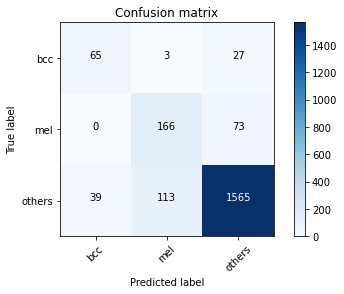

In [41]:
model_trainer.plot_confusion_matrix()  #bcc = 3, mel = 3, others = 0.5 

#using weights from /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512v2

              precision    recall  f1-score   support

         bcc       0.56      0.80      0.66        95
         mel       0.62      0.64      0.63       239
      others       0.94      0.91      0.93      1717

    accuracy                           0.88      2051
   macro avg       0.71      0.78      0.74      2051
weighted avg       0.88      0.88      0.88      2051



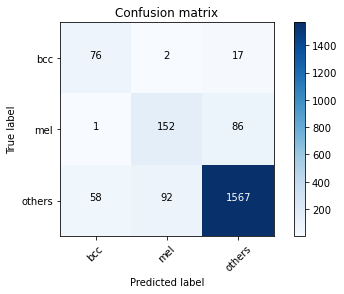

In [282]:
model_trainer.plot_confusion_matrix()  #bcc = 2.5, mel = 2.5, others = 1

#using weights from /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512

# Testing external DATASET directly with custom weighted model

Found 20552 images belonging to 3 classes.
              precision    recall  f1-score   support

         bcc       0.70      0.27      0.39      3000
         mel       0.72      0.33      0.45      3575
      others       0.75      0.95      0.84     13977

    accuracy                           0.74     20552
   macro avg       0.72      0.52      0.56     20552
weighted avg       0.74      0.74      0.71     20552



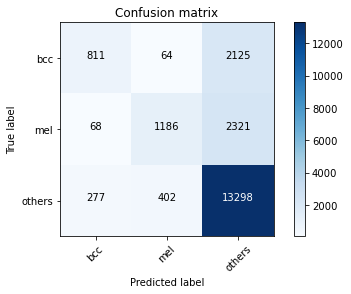

In [16]:
# to test external dataset directly
# this can be any directory but should have same class labels(case sensitive) as what the model was trained on
external_data_dir = r'/home/ubuntu/data/isic-2019/isic_train_by_class' 
model_trainer.plot_confusion_matrix(external_data_dir)

# Testing ONE external image directly with custom weighted model

In [46]:
#image file directory goes here
image = r'/home/ubuntu/data/isic-2019/isic_train_by_class/mel/ISIC_0028696.jpg'

#function which outputs probability scores of all classes and highest probability class
label, label_prob, all_labels_prob = model_trainer.predict(image)

print("Probability scores range between 0 and 1. Higher scores indicate more probability of lesion belonging to the class.""\n") 

print("\033[1m""Lesion is most likely", label, "class with a probaility of", label_prob,"\033[0m""\n")
print("All class proabilities for this lesion:",
      f"bcc - {all_labels_prob[0][0]}, mel - {all_labels_prob[0][1]}, others - {all_labels_prob[0][2]}")

error: OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [13]:
import os
os.listdir('/home/ubuntu/data/isic-2019/isic_train_by_class/mel/')

['ISIC_0065668.jpg',
 'ISIC_0059165.jpg',
 'ISIC_0024701.jpg',
 'ISIC_0072983.jpg',
 'ISIC_0060508.jpg',
 'ISIC_0025081.jpg',
 'ISIC_0056615.jpg',
 'ISIC_0060326.jpg',
 'ISIC_0059488.jpg',
 'ISIC_0014369_downsampled.jpg',
 'ISIC_0001126_downsampled.jpg',
 'ISIC_0064416.jpg',
 'ISIC_0010350.jpg',
 'ISIC_0032750.jpg',
 'ISIC_0028225.jpg',
 'ISIC_0056554.jpg',
 'ISIC_0000040_downsampled.jpg',
 'ISIC_0013549_downsampled.jpg',
 'ISIC_0061085.jpg',
 'ISIC_0062908.jpg',
 'ISIC_0062649.jpg',
 'ISIC_0028773.jpg',
 'ISIC_0068717.jpg',
 'ISIC_0032722.jpg',
 'ISIC_0055924.jpg',
 'ISIC_0028898.jpg',
 'ISIC_0012099_downsampled.jpg',
 'ISIC_0031386.jpg',
 'ISIC_0059450.jpg',
 'ISIC_0056063.jpg',
 'ISIC_0033038.jpg',
 'ISIC_0068394.jpg',
 'ISIC_0065535.jpg',
 'ISIC_0053725.jpg',
 'ISIC_0060656.jpg',
 'ISIC_0014722_downsampled.jpg',
 'ISIC_0024987.jpg',
 'ISIC_0066181.jpg',
 'ISIC_0061885.jpg',
 'ISIC_0033654.jpg',
 'ISIC_0000148_downsampled.jpg',
 'ISIC_0061643.jpg',
 'ISIC_0013917_downsampled.jpg',
 

# Training and testing on a new dataset with custom weighted ResNet50

In [26]:
#if retrain = True then imagenet is loaded for model_weights

#if retrain = False & model weights is not specified then it will use the weights of the 
    #model we trained previously using imagenet
    
#if retrain = False and model weights is specified it will reuse the weights from the directory 
   #you passed as a parameter (the model architecture for the same model must be saved)
    

    
name = 'ham_10k_resnet50_512'
model_config3 = yaml.safe_load(yaml_config3)
model_trainer = ModelTrainer.load_from_config(model_config3[name], '/home/ubuntu/data/isic-2019', 
                                              train_dir = "isic_train_by_class", test_dir = "isic_test_by_class",
                                              retrain = False, #will keep saved model weights
                                              model_weights = "/home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512"
                                             )

#set class weights
class_indices = model_trainer.train_generator.class_indices
model_trainer.class_weight[class_indices['bcc']] = 2.5
model_trainer.class_weight[class_indices['mel']] = 2.5
model_trainer.class_weight[class_indices['others']] = 1

model3 = ham_10000_resnet50()
model_trainer.register_model(model3)

attention model
Found 20552 images belonging to 3 classes.
Found 5108 images belonging to 3 classes.
Trained model exists and it will be loaded
Using weights from /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512
Trained model exists and it will be loaded
Using weights from /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_512


In [27]:
model_trainer.summary()

Model: "model_100"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_105 (InputLayer)          [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_105[0][0]                  
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [28]:
model_trainer.train(epochs=33, verbose = 1)

Epoch 1/33
643/643 [==============================] - 565s 873ms/step - loss: 1.5332 - accuracy: 0.6804 - val_loss: 0.7157 - val_accuracy: 0.7541

Epoch 00001: val_loss improved from inf to 0.71575, saving model to /home/ubuntu/data/isic-2019/models/HAM_10k_ResNet50_512/weights.h5
Epoch 2/33
643/643 [==============================] - 555s 863ms/step - loss: 1.1164 - accuracy: 0.7174 - val_loss: 0.7043 - val_accuracy: 0.7457

Epoch 00002: val_loss improved from 0.71575 to 0.70430, saving model to /home/ubuntu/data/isic-2019/models/HAM_10k_ResNet50_512/weights.h5
Epoch 3/33
643/643 [==============================] - 558s 867ms/step - loss: 1.0585 - accuracy: 0.7405 - val_loss: 0.6898 - val_accuracy: 0.7482

Epoch 00003: val_loss improved from 0.70430 to 0.68978, saving model to /home/ubuntu/data/isic-2019/models/HAM_10k_ResNet50_512/weights.h5
Epoch 4/33
643/643 [==============================] - 559s 869ms/step - loss: 1.0139 - accuracy: 0.7465 - val_loss: 0.6789 - val_accuracy: 0.7592


KeyboardInterrupt: 

              precision    recall  f1-score   support

         bcc       0.63      0.80      0.70       652
         mel       0.59      0.69      0.64       947
      others       0.89      0.80      0.84      3509

    accuracy                           0.78      5108
   macro avg       0.70      0.76      0.73      5108
weighted avg       0.80      0.78      0.79      5108



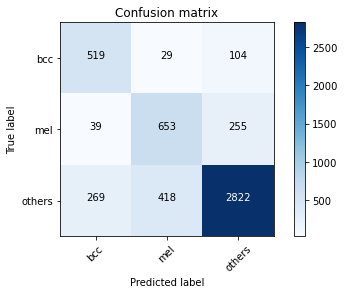

In [29]:
model_trainer.plot_confusion_matrix()